In [14]:
import sys
sys.path.append("..")

import librosa
import numpy as np
import os

from matplotlib import pyplot as plt
from pyroomasync.room import ConnectedShoeBox
from pyroomasync.simulator import simulate

from pysoundloc.least_squares_localization import least_squares_sound_localization
from pysoundloc.utils.math import compute_distance
from pysoundloc.visualization import plot_grid

room_dims = [7, 4]
source_coords = [3, 1.5]
mic_coords = np.array([[0.5, 2], [3.5, 0.5], [6.5, 2], [3.5, 3.5]])
resolution = 0.03

RT60=None snr=100 Estimated_coords=[3.0, 1.5]


/Users/ezajlerg/src/pysoundloc/notebook/../pysoundloc/visualization.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["{:.1f}".format(x) for x in x_ticks])
/Users/ezajlerg/src/pysoundloc/notebook/../pysoundloc/visualization.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["{:.1f}".format(y) for y in y_ticks])


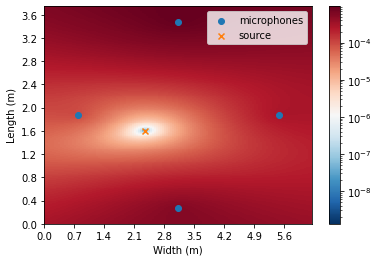

In [15]:
def simulate_least_squares_sound_localization(rt60=None, snr=100):
    input_signal, sr = librosa.load("../tests/fixtures/p225_001.wav")


    room = ConnectedShoeBox(room_dims, fs=sr, rt60=rt60)
    room.add_source(source_coords, input_signal)
    room.add_microphone_array(mic_coords)

    simulation_results = simulate(room, snr=snr)

    estimated_coords, error_grid = least_squares_sound_localization(simulation_results, sr, mic_coords, room_dims,
                                                                    resolution_in_meters=resolution)
    
    print(f"RT60={rt60} snr={snr} Estimated_coords={estimated_coords}")
    return error_grid


error_grid = simulate_least_squares_sound_localization(rt60=None, snr=100)
plot_grid(error_grid, room_dims, mic_coords, source_coords, log=True)
plt.show()

RT60=None snr=100 Estimated_coords=[3.0, 1.5]
RT60=0.6 snr=30 Estimated_coords=[3.06, 1.17]
Ground truth: [3, 1.5]


/Users/ezajlerg/src/pysoundloc/notebook/../pysoundloc/visualization.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["{:.1f}".format(x) for x in x_ticks])
/Users/ezajlerg/src/pysoundloc/notebook/../pysoundloc/visualization.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["{:.1f}".format(y) for y in y_ticks])
/var/folders/_y/3m7prfyd5pl5pw63fntczlp80000gp/T/ipykernel_76103/3333127441.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


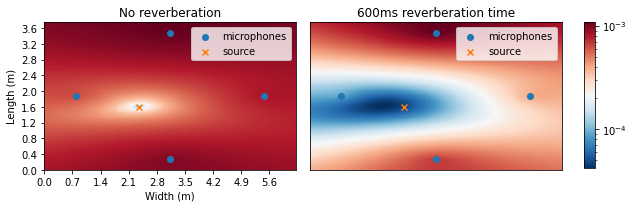

In [21]:
no_reverb = simulate_least_squares_sound_localization()
reverb = simulate_least_squares_sound_localization(rt60=0.6, snr=30)

def compare_error_grids(error_grids, labels):
    fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
    
    for i, error_grid in enumerate(error_grids):
        mesh, ax = plot_grid(error_grid, room_dims, mic_coords, source_coords, log=True, ax=axs[i], colorbar=False)
        axs[i].set_title(labels[i])
        
    # This colorbar won't probably work for more than two plots
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([1.02, 0.2, 0.02, 0.68])
    fig.colorbar(mesh, cax=cbar_ax)
    
    axs[1].axes.get_xaxis().set_visible(False)
    axs[1].axes.get_yaxis().set_visible(False)
#     axs[1].set_yticklabels([])
#     axs[1].set_ylabel("")
    fig.tight_layout()
    
    return fig, axs

print("Ground truth:", source_coords)
fig, axs = compare_error_grids([no_reverb, reverb], ["No reverberation", "600ms reverberation time"])

plt.savefig("ls_grid.pdf")

In [4]:
rt60_range = np.arange(0.2, 1, 0.1)
snr_range = np.arange(50, -10, -10)

errors = np.zeros((rt60_range.shape[0], snr_range.shape[0]))

for i, rt60 in enumerate(rt60_range):
    for j, snr in enumerate(snr_range):
        estimated_coords = plot_least_squares_sound_localization(rt60=rt60, snr=snr)
        plt.show()
        
        errors[i, j] = compute_distance(estimated_coords, source_coords)

NameError: name 'plot_least_squares_sound_localization' is not defined

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
mesh = ax.pcolormesh(errors, cmap="RdBu_r")
plt.colorbar(mesh, ax=ax)
ax.set_xticklabels(["{:.1f}".format(x) for x in rt60_range])
ax.set_yticklabels(["{:.1f}".format(y) for y in snr_range])
ax.set_xlabel("RT60 (seconds)")
ax.set_ylabel("SNR (dB)")

ax.yaxis.set_major_locator(plt.MaxNLocator(snr_range.shape[0]))